1. 如何利用Python的控制语句与基本内置计算方法，构造一个二叉树模型；
2. 如何使用类封装的方式，抽象二叉树算法，并进行扩展；
3. 利用继承的方法为已有二叉树算法增加美式期权算法。

In [17]:
import numpy as np
import math
import seaborn as sns
from matplotlib import pylab
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# 1. Binomial Tree 二叉树算法Python描述

一个基本的二叉树机构由以下三个参数决定：

1. up 标的资产价格向上跳升的比例， up必然大于1 （对应上图中的 u)
2. down 标的资产价格向下跳升的比例， down必然小于1 (对应上图中的 d)
3. upProbability 标的资产价格向上跳升的概率

这里我们用一个具体的例子，使用Python实现二叉树算法。以下为具体参数 (Call option)：

- ttm 到期时间，单位年
- tSteps 时间方向步数
- r 无风险利率
- d 标的股息率
- sigma 波动率
- strike 期权行权价
- spot 标的现价

In [2]:
ttm = 3.0
tSteps = 25
r = 0.03
d = 0.02
sigma = 0.2
strike = 100.0
spot = 100.0

jarrow rudd tree 

In [3]:
dt = ttm / tSteps
up = np.exp((r - d - 0.5*sigma*sigma)*dt + sigma*np.sqrt(dt))
down = np.exp((r - d - 0.5*sigma*sigma)*dt - sigma*np.sqrt(dt))
discount = np.exp(-r*dt)

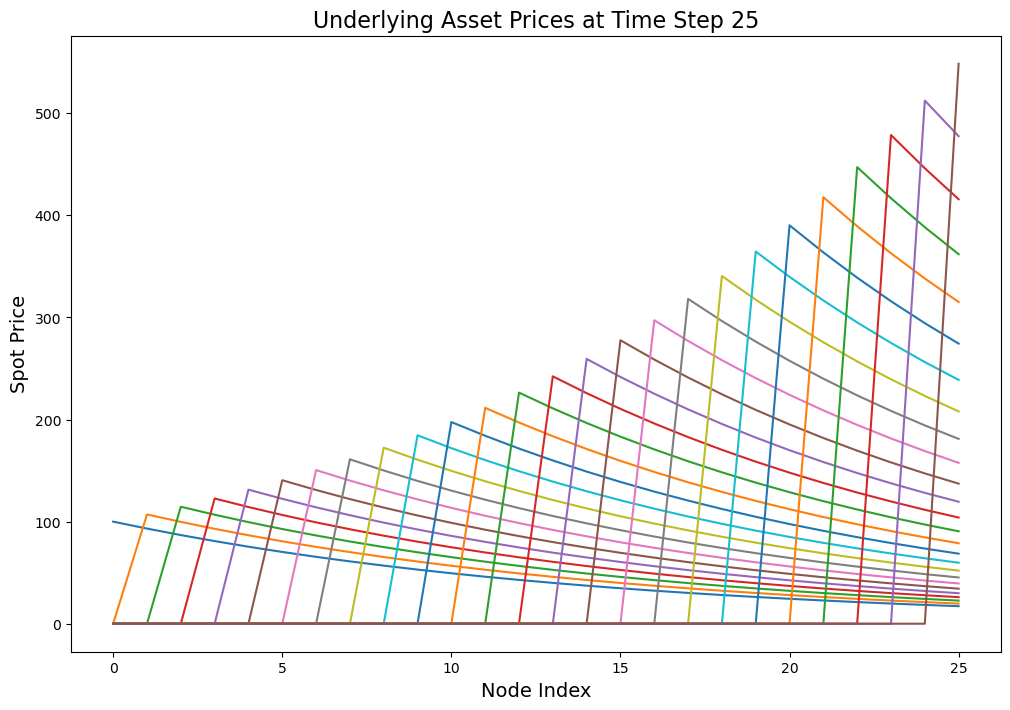

In [4]:
lattice = np.zeros((tSteps+1,tSteps+1))
lattice[0][0]= spot
for i in range(tSteps):
    for j in range(i+1):
        lattice[i+1][j+1] = up*lattice[i][j]
    lattice[i+1][0] = down * lattice[i][0]

plt.figure(figsize=(12, 8))
pylab.plot(range(tSteps+1),lattice)
pylab.title('Underlying Asset Prices at Time Step {}'.format(tSteps), fontsize=16)
pylab.xlabel('Node Index', fontsize=14)
pylab.ylabel('Spot Price', fontsize=14)
plt.show()


# 2. 从“树”到“森林”—— 面向对象方式实现二叉树算法
之前的部分展示了一个树算法的基本结构。但是现在的实现由很多缺点：

没有明确接口，作为用户优雅简洁的使用既有算法；
没有完整封装，十分不利于算法的扩展；
下面我们将给出一个基于Python类的二叉树算法实现，实际上我们通过上面的实验性探索，发现整个程序可以拆成三个互相独立的功能模块：

二叉树框架

树的框架结构，包括节点数以及基本参数的保存；

二叉树类型描述

具体数算法的参数，例如上例中的 Jarrow Rudd树；

偿付函数

到期的偿付形式，即为Payoff Function。


## 2.1 二叉树框架（BinomialTree）
这个类负责二叉树框架的构造，也是基本的二叉树算法的调用入口。它有三个成员：

构造函数（__init__）

负责接受用户定义的具体参数，例如：spot等；真正二叉树的构造方法，由私有方法_build_lattice以及传入参数treeTraits共同完成；

树构造细节（_build_lattice）

接手具体的树构造过程，这里需要依赖根据treeTraits获取的参数例如：up, down。

树回溯（roll_back）

从树的最茂盛枝叶节点向根节点回溯的过程。最终根节点的值即为期权的价值。这里它要求的参数是一个pay_off函数。

In [16]:
class BinomialTree:
    def __init__(self, spot, riskFree, dividend, tSteps, maturity, sigma, treeTraits):
        self.dt = maturity / tSteps
        self.spot = spot
        self.r = riskFree
        self.d = dividend
        self.tSteps = tSteps
        self.discount = math.exp(-self.r*self.dt)
        self.v = sigma
        self.up = treeTraits.up(self)
        self.down = treeTraits.down(self)
        self.upProbability = treeTraits.upProbability(self)
        self.downProbability = 1.0 - self.upProbability
        self._build_lattice()

    def _build_lattice(self):
        '''
        完成构造二叉树的工作
        '''
        self.lattice = np.zeros((self.tSteps+1, self.tSteps+1))
        self.lattice[0][0] = self.spot
        for i in range(self.tSteps):
            for j in range(i+1):
                self.lattice[i+1][j+1] = self.up * self.lattice[i][j]
            self.lattice[i+1][0] = self.down * self.lattice[i][0]

    def roll_back(self, payOff):
        '''
        节点计算，并反向倒推
        '''
        for i in range(self.tSteps,0,-1):
            for j in range(i,0,-1):
                if i == self.tSteps:
                    self.lattice[i-1][j-1] = self.discount * (self.upProbability * payOff(self.lattice[i][j]) 
                                                              + self.downProbability * payOff(self.lattice[i][j-1]))
                else:
                    self.lattice[i-1][j-1] = self.discount * (self.upProbability *  self.lattice[i][j] 
                                                              + self.downProbability * self.lattice[i][j-1])

## 2.2 二叉树类型描述（Tree Traits）
正像我们之前描述的那样，任意的树只要描述三个方面的特征就可以。所以我们设计的Tree Traits类只要通过它的静态成员返回这些特征就可以：

- up 返回向上跳升的比例；
- down 返回向下调降的比例；
- upProbability 返回向上跳升的概率

下面的类定义了 Jarrow - Rudd 树的描述：

In [6]:
class JarrowRuddTraits:
    @staticmethod
    def up(tree):
        return np.exp((tree.r - tree.d - 0.5*tree.v*tree.v)*tree.dt + tree.v*np.sqrt(tree.dt))

    @staticmethod
    def down(tree):
        return np.exp((tree.r - tree.d - 0.5*tree.v*tree.v)*tree.dt - tree.v*np.sqrt(tree.dt))

    @staticmethod
    def upProbability(tree):
        return 0.5

我们这里再给出另一个 Cox - Ross - Rubinstein 树的描述：

In [7]:
class CRRTraits:  
    @staticmethod
    def up(tree):
        return np.exp(tree.v * np.sqrt(tree.dt))

    @staticmethod
    def down(tree):
        return np.exp(-tree.v * np.sqrt(tree.dt))

    @staticmethod
    def upProbability(tree):
        return 0.5 + 0.5 * (tree.r - tree.d - 0.5 * tree.v*tree.v) * tree.dt / tree.v / np.sqrt(tree.dt)


## 2.3 偿付函数（pay_off）
这部分很简单，就是一元函数，输入为标的价格，输出的偿付收益，对于看涨期权来说就是：

In [8]:
def pay_off(spot):
    global strike
    return max(spot - strike, 0.0)

## 2.4 组装
让我们三部分组装起来，现在整个调用过程变得什么清晰明了，同时最后的结果和第一部分是完全一致的。

In [9]:
testTree = BinomialTree(spot, r, d, tSteps, ttm, sigma, JarrowRuddTraits)
testTree.roll_back(pay_off)
print('Tree Price： %.4f' % testTree.lattice[0][0])


Tree Price： 14.2663


这里我们想更进一步，用我们现在的算法框架来测试二叉树的收敛性。
这里我们用来作比较的算法即为之前描述的 Jarrow - Rudd 以及 Cox - Ross - Rubinstein 树：


In [10]:
stepSizes = range(25, 500,25)
jrRes = []
crrRes = []
for tSteps in stepSizes:
    # Jarrow - Rudd 结果
    testTree = BinomialTree(spot, r, d, tSteps, ttm, sigma, JarrowRuddTraits)
    testTree.roll_back(pay_off)
    jrRes.append(testTree.lattice[0][0])

    # Cox - Ross - Rubinstein 结果
    testTree = BinomialTree(spot, r, d, tSteps, ttm, sigma, CRRTraits)
    testTree.roll_back(pay_off)
    crrRes.append(testTree.lattice[0][0])

In [11]:
def  BSMPrice(strike,spot, r ,d,sigma,T,type='call'):
    d1 = (np.log(spot / strike)+(r+(0.5*sigma**2)*T))/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if type == "call":
        N_d1 = norm.cdf(d1, 0, 1)
        N_d2 = norm.cdf(d2, 0, 1)
        price = N_d1 * spot* np.exp(-(d)*T) - N_d2 * strike * np.exp(-(r)*T)
    elif type =="put":
        N_d1 = norm.cdf(-d1, 0, 1)
        N_d2 = norm.cdf(-d2, 0, 1)
        price = strike * np.exp(-(r) * T) * N_d2 - spot * N_d1* np.exp(-(d)*T)
    else:
        raise ValueError("unknow type")
    return(price)

Text(0.5, 1.0, 'Binomial Tree Convergence Test')

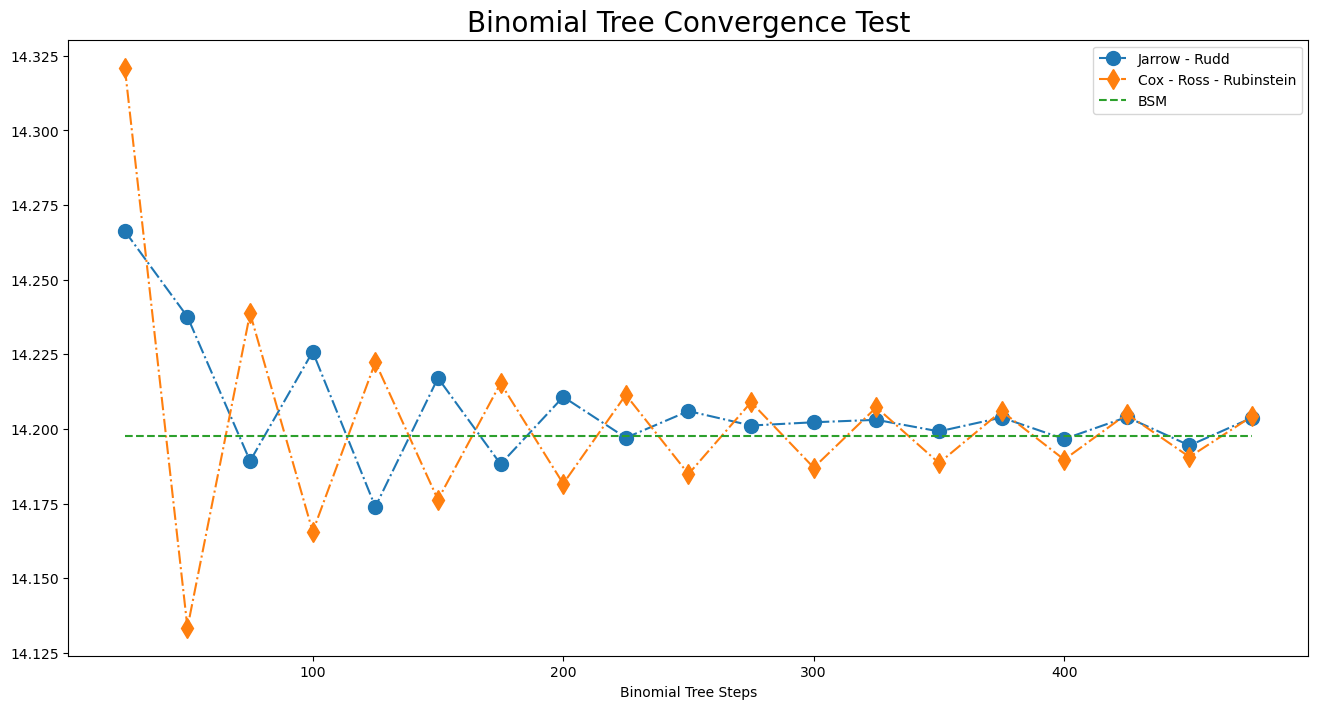

In [12]:
anyRes = [BSMPrice(strike,spot, r,d ,sigma,ttm)] * len(stepSizes)

pylab.figure(figsize = (16,8))
pylab.plot(stepSizes, jrRes, '-.', marker = 'o', markersize = 10)
pylab.plot(stepSizes, crrRes, '-.', marker = 'd', markersize = 10)
pylab.plot(stepSizes, anyRes, '--')
pylab.legend(['Jarrow - Rudd', 'Cox - Ross - Rubinstein', 'BSM'])
pylab.xlabel('Binomial Tree Steps')
pylab.title('Binomial Tree Convergence Test', fontsize = 20)


# 3. 新想法 —— 美式期权？

如果只是普通欧式期权的话，二叉树就是多此一举的做法。但是由于二叉树天然的反向回溯的特性，使得它特别适合处理有提前行权结构的期权产品。这里我们将以美式期权为例。

美式期权的行权结构在二叉树结构下处理起来特别简单，要做的只是在每个节点上做这样的比较：



这里的 ExerciseValue 就是立即行权的价值， EuropeanValue为对应节点的欧式价值。

为了实现上面的比较，我们需要扩展原先的算法，这个我们可以通过Python的类继承在原先的类之上添加新功能：

In [13]:
class ExtendBinomialTree(BinomialTree):

    def roll_back_american(self, payOff):
        '''
        节点计算，并反向倒推
        '''
        for i in range(self.tSteps,0,-1):
            for j in range(i,0,-1):
                if i == self.tSteps:
                    europeanValue = self.discount * (self.upProbability * payOff(self.lattice[i][j]) + self.downProbability * payOff(self.lattice[i][j-1]))
                else:
                    europeanValue = self.discount * (self.upProbability *  self.lattice[i][j] + self.downProbability * self.lattice[i][j-1])
                # 处理美式行权
                exerciseValue = payOff(self.lattice[i-1][j-1])
                self.lattice[i-1][j-1] = max(europeanValue, exerciseValue)

In [14]:
stepSizes = range(25, 500,25)
jrRes = []
crrRes = []
for tSteps in stepSizes:
    # Jarrow - Rudd 结果
    testTree = ExtendBinomialTree(spot, r, d, tSteps, ttm, sigma, JarrowRuddTraits)
    testTree.roll_back_american(pay_off)
    jrRes.append(testTree.lattice[0][0])

    # Cox - Ross - Rubinstein 结果
    testTree = ExtendBinomialTree(spot, r, d, tSteps, ttm, sigma, CRRTraits)
    testTree.roll_back_american(pay_off)
    crrRes.append(testTree.lattice[0][0])

Text(0.5, 1.0, 'Binomial Tree American Option')

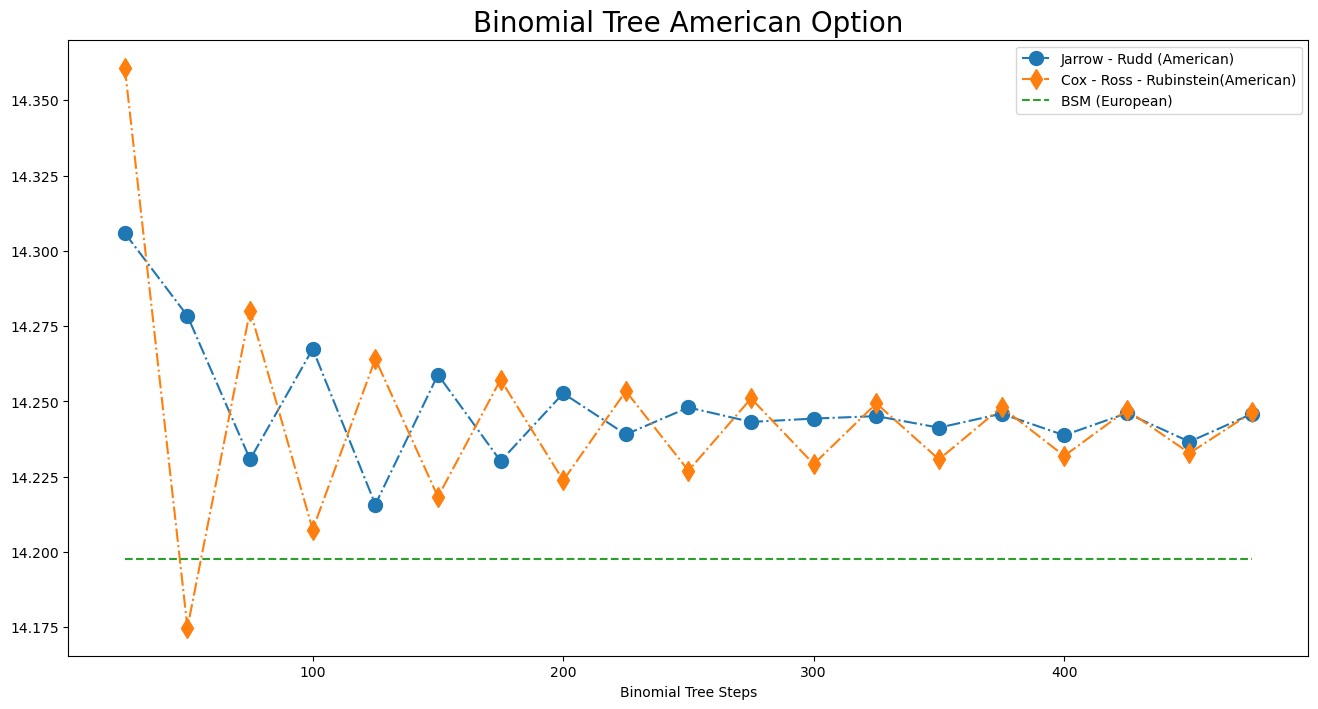

In [19]:
anyRes = [BSMPrice(strike,spot, r,d ,sigma,ttm)] * len(stepSizes)

pylab.figure(figsize = (16,8))
pylab.plot(stepSizes, jrRes, '-.', marker = 'o', markersize = 10)
pylab.plot(stepSizes, crrRes, '-.', marker = 'd', markersize = 10)
pylab.plot(stepSizes, anyRes, '--')
pylab.legend(['Jarrow - Rudd (American)', 'Cox - Ross - Rubinstein(American)', 'BSM (European)'])
pylab.xlabel('Binomial Tree Steps')
pylab.title('Binomial Tree American Option', fontsize = 20)
